## Grover's Algorithm Implementation in Qiskit

In [1]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator
import numpy as np

In [2]:
# First we define the Oracle for a specific example the solution is a particular bit string, say 101 for a
# 3 qubit system

def grover_oracle(n, solution):
    # Create a quantum circuit
    qc = QuantumCircuit(n)

    # Apply X-gates to the qubits that correspond to '0' in the solution
    for qubit in range(n):
        if solution[qubit] == '0':
            qc.x(qubit)

    # Apply a multi-controlled Z-gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)

    # Apply X-gates again
    for qubit in range(n):
        if solution[qubit] == '0':
            qc.x(qubit)

    # Convert to gate
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

In [3]:
# Implementation for a diffuser to amplify the probability of the solution state

def grover_diffuser(n):
    qc = QuantumCircuit(n)
    
    # Apply transformation |s> -> |00..0> (H-gates)
    qc.h(range(n))
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    qc.x(range(n))
    
    # Do multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    
    # Apply transformation |11..1> -> |00..0>
    qc.x(range(n))
    
    # Apply transformation |00..0> -> |s>
    qc.h(range(n))

    # Convert to gate
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate


In [28]:
# Bringing the circuit together

solution = '101101101101101101101101101101101101101101101101101101101101101101101101101101101'  # The solution string
n = len(solution)  # Number of qubits
print(n)
qc = QuantumCircuit(n, n)

# Apply Hadamard gates
qc.h(range(n))

# Add the oracle
oracle_gate = grover_oracle(n, solution)
qc.append(oracle_gate, range(n))

# Add the diffuser
diffuser_gate = grover_diffuser(n)
qc.append(diffuser_gate, range(n))

# Measure the qubits
qc.measure(range(n), range(n))

# qc.draw(output='mpl')

81


/var/folders/zn/g_jfcp8s505gzx7nk3gggjnr0000gn/T/ipykernel_95022/1069033121.py:15: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
/var/folders/zn/g_jfcp8s505gzx7nk3gggjnr0000gn/T/ipykernel_95022/3764361831.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli


Counts(ideal): {'000': 19, '010': 33, '110': 33, '100': 34, '001': 22, '111': 24, '011': 34, '101': 825}


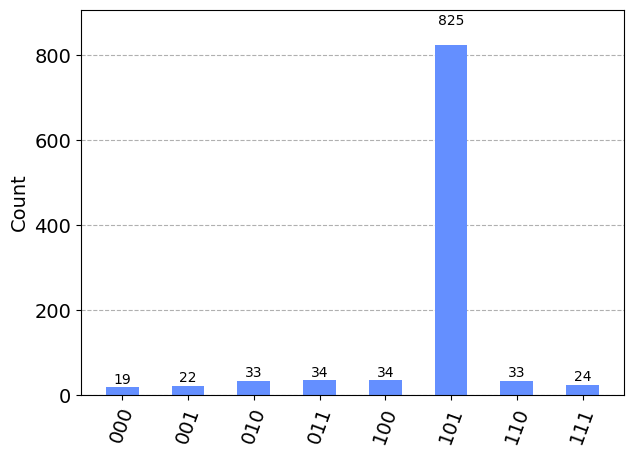

In [24]:
# Running the circuit
from qiskit_aer import AerSimulator

# we will use Aer's qasm_simulator
aersim = AerSimulator()

# get the results and the counts and plot a histogram
result_ideal = aersim.run(qc.decompose(), shots = 1024).result()
counts_ideal = result_ideal.get_counts(0)
print('Counts(ideal):', counts_ideal)

plot_histogram(counts_ideal)

Counts(noise): {'010': 20, '000': 33, '011': 32, '111': 45, '001': 67, '100': 131, '110': 37, '101': 659}


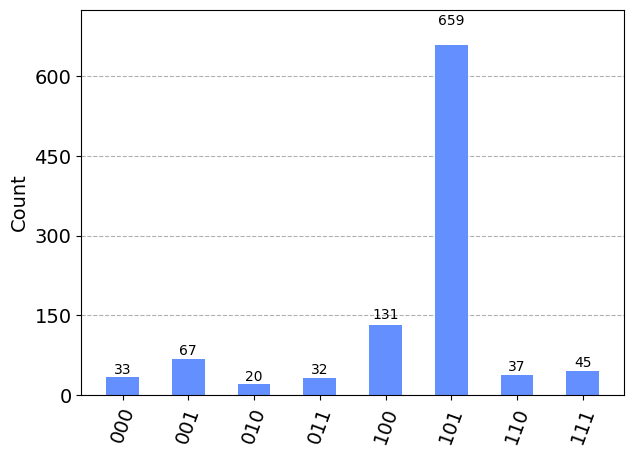

In [26]:
from qiskit.providers.fake_provider import FakeManilaV2

# Construct a noisy simulator backend from an IBMQ backend
# This simulator backend will be automatically configured
# using the device configuration and noise model
backend = FakeManilaV2()
aersim_backend = AerSimulator.from_backend(backend)

# Perform noisy simulation
result_noise = aersim_backend.run(qc.decompose(), shots = 1024).result()
counts_noise = result_noise.get_counts(0)

print('Counts(noise):', counts_noise)

plot_histogram(counts_noise)

Text(0, 0.5, 'Execution Time')

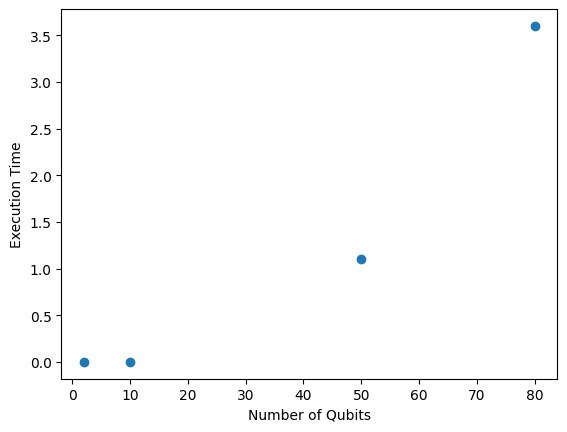

In [29]:
# plot for scalability of circuit

import matplotlib.pyplot as plt

num_qubits = [2, 10, 50, 80]
exec_time = [0.0, 0.0, 1.1, 3.6]

plt.scatter(num_qubits, exec_time)
plt.xlabel("Number of Qubits")
plt.ylabel("Execution Time")